# <font color='yellow' style='font-size: 30px;'>ROTEIRO PARA ANÁLISE DE CIRCUITOS</font> <hr style='border: 2px solid yellow;'>

## <span style=color:yellow> Obtendo equações do sistema

A obtenção de equações de qualquer sistema passa pelo conhecimento prévio e teórico sobre a física em questão. Teoria de controle, na realidade, se aplica em qualquer engenharia. 

Como temos um forte interesse em utilizar eletrônica e computação para controle, convém abortar circuitos elétricos para entendimento dessas técnicas, mas aí está um fato curioso: em nenhum momento se espera que um engenheiro de controle e automação projete um circuito elétrico estável — e muito menos um sistema dinâmico estável.

### Circuito RLC em série <hr style='line: 1px solid white;'>

<p style="text-align:center">
    <img src="./imagens/RCL_serie.png">
</p>

Deste circuito temos as duas seguintes equações — por Kirchoff de tensões:

\begin{equation}
\begin{cases}
L\frac{di}{dt} + \frac{R}{L} \frac{de_o}{dt} + \frac{1}{C} \int i \, dt = e_i  \\
\frac{1}{C} \int i \, dt = e_o
\end{cases}
\tag{1}
\end{equation}

Se levarmos para o domínio da frequência, sabendo que:

$ \boxed {A\frac{d}{dt} = As}$ 

$ \boxed {A \int i \, dt = \frac{1}{As}}$

Teremos:

\begin{equation}
\begin{cases}
LsI(s) + RI(s) + \frac{1}{Cs}I(s) = E_i(s)  \\
\frac{1}{Cs}I(s)  = E_o(s)
\end{cases}
\tag{2}
\end{equation}

Então, a função transferência se torna:

\begin{equation}
\frac{E_o(s)}{E_i(s)} = \frac{1}{LCs^2 + RCs + 1}
\tag{3}
\end{equation}

A função transferência já é um grande negócio. Ela indica como o circuito transfere informação entre a entrada e a saída. Aqui, já poderíamos iniciar uma simulação e verificar se faz sentido com o circuito em questão. 

Para obter o *'Espaço de Estados'* você precisará identificar a equação diferencial que governa o circuito. Uma maneira de fazer isso é isolar a derivada de maior grau da função transferência (*eq.3*), que é justamente $s^2$.

\begin{equation}
E_os^2 + E_o\frac{R}{Ls} + E_o\frac{1}{Lc} = E_i\frac{1}{LC} \iff \ddot{e}_o + \frac{R}{L}\dot{e}_o + \frac{1}{LC}e_o = \frac{1}{LC}e_i
\tag{4}
\end{equation}

#### **O que é o 'Espaço de Estados'?**

De saída, é uma forma de representar um sistema de ordem $n$ em um set de equações de $1º$ ordem. Só por isso, já temos toda a algebra linear disponível para nos ajudar a encontrar o estado do sistema em qualquer configuração de variáveis. Mas ainda podería dar outros motivos muito bons para tentarmos produzir essa representação matricial:

- Existem muitos métodos numéricos para resolver esse tipo de problema;
- Existem muitas técnicas de controle baseadas em Espaço de estado — justamente porque existem métodos numéricos poderosos;

Então, por exemplo: Filtros Kalman, LQR, Controle Robusto, MPC, etc. São todos métodos de controle baseados em Espaço de Estados. 

No caso de sistemas contínuos, lineares e invariantes no tempo (LTI) — se o seu sistema não cumprir esses requisitos, nada aqui tem valor para você — podemos dizer que o sistema consiste em 4 matrizes:

 - A: combinação linear de $\dot{x}(t)$ e ${x}(t)$, em outras palavras, determina como todos os estados internos estão relacionados;
 - B: determina como os inputs excitam o sistema, em outras palavras, quais estados internos são afetados pelos inputs;
 - C: representa como os estados precisam ser combinados para encontrar as saídas desejadas;
 - D: representa a operação crua ocorrendo em cada input;

Multiplicadas adequadamente por vetores 4 vetores:

 - $\dot{x}(t)$: vetor que representa a Dinâmica do sistema — determina como os estados vão mudar, portanto;
 - ${x}(t)$: vetor que representa o Estado do sistema — adequamente conhecido como "vetor de estados";
 - ${u}(t)$:
 - ${y}(t)$: vetor de saídas do sistema — é não só aquilo que você quer saber, mas manter controlado;

## <span style=color:yellow> Biblioteca 'Controls' para simulação

### <span style=color:yellow> import

In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as plt
import control as ct

print('Versão do pandas -> %s' % pd.__version__)
print('Versão do numpy -> %s' % np.__version__)
print('Versão do scipy -> %s' % sp.__version__)
# print('Versão do matplotlib -> %s' % matplotlib.__version__)
print('Versão do control -> %s' % ct.__version__)

Versão do pandas -> 1.5.0
Versão do numpy -> 1.23.4
Versão do scipy -> 1.9.2
Versão do control -> 0.9.3.post2


### <span style=color:yellow> Espaço de estados

In [6]:
A = [[1, 2], [2, 1]]
B = [[1, 2], [2, 1]]
C = [[1, 2], [2, 1]]
D = [[1, 2], [2, 1]]

sys = ct.ss(A, B, C, D,)
sys

<LinearIOSystem:sys[3]:['u[0]', 'u[1]']->['y[0]', 'y[1]']>

# <font color='yellow' style='font-size: 30px;'>ANÁLISE DE RESPOSTA TRANSITÓRIA e REGIME ESTACIONÁRIO</font> <hr style='border: 2px solid yellow;'>

### O que diabos é essa tal de análise?

A análise consiste em pegar um sistema de controle e perturba-lo com um sinal conhecido, o que é chamado de "teste". Existem vários sinais de teste, como degrau, rampa, parábola de aceleração e impulso. A ideia é provocar um sinal desses na entrada do sistema e ver como ele se comporta. Isso é interessante porque esses sinais são conhecidos, de forma que a saída do sistema carregue alguma informação intrínseca do mesmo, a chamada "resposta característica" do sistema.

É interessante testar seu sistema nas condições em que ele for projetado para operar, por exemplo:

- Se as entradas de um sistema de controle são funções de tempo que variam gradualmente, então a rampa em função do tempo pode ser um bom sinal de teste;
- Se um sistema estiver sujeito a variações bruscas de entrada, a função degrau poderá ser um bom sinal de teste;
- Se o sistema estiver sujeito a entradas de impacto, uma função impulso poderá ser a melhor opção.

#### A resposta:

A resposta do sistema fica dividida entre uma ***parte transitória*** — porque se é um sistema de controle, o que se deve observar é um disturbio e logo após um retorno para um estado "estável" — e outra ***estacionária***. Dito isso, vamos ter as seguintes definições em mente:

1. Um sistema de controle está em equilíbrio se, na ausência de qualquer distúrbio ou sinal de entrada, a saída permanece no mesmo estado;

2. Um sistema de controle linear e invariante no tempo é estável se a saída sempre retorna ao estado de equilíbrio quando o sistema é submetido a uma condição inicial;

3. Um sistema de controle linear e invariante no tempo é criticamente estável se as oscilações do sinal de saída se repetirem de maneira contínua;

4. É instável se a saída divergir sem limites a partir do estado de equilíbrio quando o sistema for sujeito a uma condição inicial.

#### Na prática a teoria é outra:

Na verdade, os sistemas contém elementos armazenadores de energia, o que implica que eles, os sistemas, não irão responder instantaneamente os sinais de entrada. Além disso, apresentam transitórios periódicos. A constante de tempo é algo que irá influenciar totalmente essa resposta do sistema. Quanto menor a constante de tempo, mais rápida será a resposta — a constante é calculada, sempre, a partir dos elementos armazenadores de energia.

Por exemplo, para um circuito RLC em série, essa constante seria dada por $$\tau = \frac{L}{R}$$

**Td (tempo de atraso)**: é o tempo que a resposta leva para sair do repouso até começar a se mover.

**Tr (tempo de subida)**: é o tempo que a resposta leva para ir do valor inicial até o valor final pela primeira vez.

**Tp (tempo de pico)**: é o tempo que a resposta leva para atingir o valor máximo.

**Mp (máximo sobressinal)**: é a porcentagem em que a resposta excede o valor final, em relação a esse valor final.

**Ts (tempo de acomodação)**: é o tempo que a resposta leva para atingir um estado estacionário, ou seja, para ficar próxima do valor final e permanecer nessa região sem oscilar excessivamente. 
    
    Geralmente é definido como o tempo que leva para a resposta estar dentro de uma faixa em torno do valor final, como por exemplo, 2% ou 5%.


## <span style=color:yellow> Análise para sistemas de primeira Ordem <hr style='line: 1px solid yellow;'>

<p style="text-align:center">
    <img src="./imagens/diagrama_bloco_1ordem.png">
</p>

A função transferência deste diagrama é óbviamente dada por: 

$$\frac{C(s)}{R(s)} = \frac{1}{Ts+1} \tag{1}$$

Nesse sentido, para saber a resposta do circuito $C(s)$, precisamos fazer com que $R(s)$ seja uma função degrau. Essa função, no domínio da frequência é dada por $\frac{1}{s}$, logo, temos:

$$C(s) = \frac{1}{Ts+1} \tag{1}$$


\begin{equation}
\tag{1}
\end{equation}



Para obter as frações parciais dessa expressão, podemos usar a técnica de frações parciais. Primeiro, escrevemos a expressão como uma soma de frações parciais com denominadores lineares distintos.

\begin{equation}
\frac{1}{Ts+1} * \frac{1}{s} = \frac{A}{Ts+1} + \frac{B}{s}
\end{equation}

Agora, multiplicando ambos os lados por $(Ts+1)s$, obtemos:

\begin{equation}
1 = As + B(Ts+1)
\end{equation}

Para encontrar $A$, podemos fazer $s=0$:

\begin{equation}
1 = B(Ts+1) \Rightarrow B = \frac{1}{Ts+1} \Big|_{s=0} = \frac{1}{1} = 1
\end{equation}

Para encontrar $B$, podemos fazer $s=-1/T$:

\begin{equation}
1 = A\Big(\frac{-1}{T}\Big) \Rightarrow A = \frac{-1}{Ts+1} \Big|_{s=-1/T} = \frac{1}{T}
\end{equation}

Portanto, a expressão pode ser escrita como:

\begin{equation}
\frac{1}{Ts+1} * \frac{1}{s} = \frac{1}{T} \cdot \frac{1}{Ts+1} - \frac{1}{s}
\end{equation}

## <span style=color:yellow> Critério de Routh <hr style='line: 1px solid yellow;'>

A pergunta é : Sob quais condições um sistema se tornará instável? Se for instável, como deveríamos estabilizá-lo? 

> Se e somente se todos os polos de malha fechada estiverem situados no semiplano esquerdo do plano s. 

O critério nos diz se existem ou não raízes instáveis em uma equação polinomial, sem que seja necessário resolvê-la. Este critério de estabilidade aplica-se somente a polinômios com um número finito de termos.

c:\Users\Mathe\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


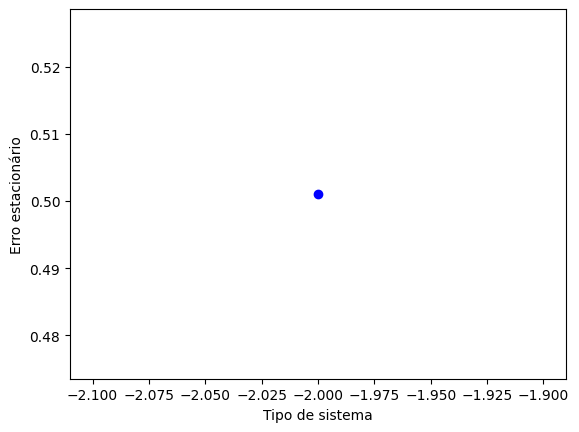

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control

# Definir as funções de transferência G1(s), G2(s), H(s) e Gc(s)
G1 = control.TransferFunction([1], [1, 2, 1])
G2 = control.TransferFunction([1], [1, 3])
H = control.TransferFunction([1], [1])
Gc = control.TransferFunction([1], [1, 1])

# Definir a função de transferência em malha fechada G(s)
G = Gc * G1 * H / (1 + Gc * G1 * H)

# Definir o vetor de tempo de simulação
T = np.linspace(0, 10, 1000)

# Calcular a resposta ao degrau do sistema para um degrau unitário de referência
t, y = control.step_response(G, T)

# Calcular o erro estacionário para cada valor de referência R(s)
e_ss = abs(1 - y[-1])

# Calcular o tipo de sistema
system_type = control.poles(G)[0]

# Plotar o erro estacionário em função do tipo de sistema
plt.plot(system_type, e_ss, 'bo')
plt.xlabel('Tipo de sistema')
plt.ylabel('Erro estacionário')
plt.show()